# Text classification with Transformer

Se implementa un bloque Transformer como una capa Keras.

### Importar librerías

In [26]:
import keras
import pandas as pd
from keras import ops
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

### Implementar un Bloque Transformer como una Layer

In [2]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

### Implementar una Layer Embedding

Dos capas de embedding, una para tokens y otra para el índice de tokens (posiciones).

In [3]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

### Cargar el dataset

In [4]:
df = pd.read_csv("dataset/updated_language_detection.csv")
df.describe()

,Text,Language
count,20821,20821
unique,20821,21
top,aprilie sonda spațială messenger a nasa și-a ...,Thai
freq,1,1000


### Preprocesar el Texto

- Tokenización: Convertir el texto en tokens (palabras).
- Padding: Asegurarse de que todas las secuencias de texto tengan la misma longitud.

In [5]:
# Unir todos los textos en una lista
texts = df['Text'].values

# Inicializar el Tokenizer para convertir texto en índices
maxlen=300
vocab_size = 200000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)

# Convertir los textos a secuencias de índices
X = tokenizer.texts_to_sequences(texts)

# Padding para asegurar que todas las secuencias tengan la misma longitud
X = pad_sequences(X, maxlen=maxlen)
X[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

### Codificar las Etiquetas

Codificamos las etiquetas (idiomas) en valores numéricos.

In [6]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Language'])
y[:5]

array([ 3, 16, 18, 17,  1])

### Dividir el dataset en conjuntos de entrenamiento y prueba

Se utiliza stratify para mantener la proporción de clases en los conjuntos de entrenamiento y prueba.

Train: 70%

Validation: 10%

Test: 20%

In [7]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['Language'])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

print("Entrenamiento:", X_train.shape, y_train.shape)
print("Validación:", X_val.shape, y_val.shape)
print("Prueba:", X_test.shape, y_test.shape)

Entrenamiento: (14574, 300) (14574,)
Validación: (2082, 300) (2082,)
Prueba: (4165, 300) (4165,)


### Construcción del Modelo Transformer

Creamos la arquitectura del modelo con las layers implementadas previamente de embedding y el bloque transformer. Se agrega una capa GlobalAveragePooling1D para promediar las salidas de la capa de salida del transformer. Finalmente, se agrega una capa densa con activación softmax para clasificar las etiquetas.

In [8]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
#x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
#x = layers.Dropout(0.1)(x)
outputs = layers.Dense(len(label_encoder.classes_), activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model.summary()

2024-12-13 14:00:20.921440: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 300, 32)        │     6,409,600 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 300, 32)        │        10,656 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 21)             │           441 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,421,357 (24.50 MB)

 Trainable params: 6,421,357 (24.50 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenar el modelo

In [9]:
history = model.fit(
    X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val)
)

Epoch 1/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 102s 211ms/step - accuracy: 0.3017 - loss: 2.3396 - val_accuracy: 0.9664 - val_loss: 0.1496
Epoch 2/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 95s 208ms/step - accuracy: 0.9798 - loss: 0.1053 - val_accuracy: 0.9803 - val_loss: 0.0894
Epoch 3/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 94s 207ms/step - accuracy: 0.9935 - loss: 0.0354 - val_accuracy: 0.9793 - val_loss: 0.0858
Epoch 4/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 144s 210ms/step - accuracy: 0.9968 - loss: 0.0146 - val_accuracy: 0.9851 - val_loss: 0.0718
Epoch 5/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 95s 207ms/step - accuracy: 0.9960 - loss: 0.0138 - val_accuracy: 0.9851 - val_loss: 0.0746
Epoch 6/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 104s 229ms/step - accuracy: 0.9979 - loss: 0.0081 - val_accuracy: 0.9784 - val_loss: 0.0969
Epoch 7/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 95s 208ms/step - accuracy: 0.9978 - loss: 0.0079 - val_accuracy: 0.9851 - val_loss: 0.0840
Epoch 8/10
456/456 ━━━━━━━━━━━━━━━━━━━━ 96s 210ms/step - accuracy: 0.9980 - loss

### Evaluación del Modelo

In [18]:
score, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Accuracy: {accuracy * 100:.2f}%')

131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9834 - loss: 0.0889
Accuracy: 98.27%


### Guardar el modelo

In [19]:
model.save("models/transformer_model.keras")

### Ejemplos de Predicciones

In [20]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
language_names = label_encoder.classes_
decoded_texts = tokenizer.sequences_to_texts(X_test)

for i in range(5):
    predicted_language = language_names[y_pred[i]]
    real_language = language_names[y_test[i]]

    print(f"Texto: {decoded_texts[i]}")
    print(f"Predicción: {predicted_language} (Real: {real_language})\n")

131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step
Texto: एथलीटों ने दो या दो से अधिक पदक जीते जिसमें पांच एथलीटों ने तीन पदक जीते। खेलों में बेलारूस की दरिया डोमरेचेवा ने तीन स्वर्ण पदक जीते थे जबकि फ्रांस के मार्टिन चौकाड ने दो स्वर्ण और एक रजत पदक जीते थे। महिला विश्व कप विजेता टोरा बर्गर ने प्रत्येक रंग का पदक जीता जबकि टीम के साथी टिरिल एखॉफ ने अपने पहले खेलों में एक स्वर्ण और दो कांस्य पदक जीते। चेक एथलीट ओंड्रजेज मोरेवेक ने दो रजत और एक कांस्य पदक जीता।
Predicción: Hindi (Real: Hindi)

Texto: اکتوبر گريگورين سال کا دسواں مہينہ ہے۔ پرانی رومی تقویم میں یہ آٹھواں مہینہ ہوتا تھا چنانچہ اسے اکتوبر کہا جاتا تھا اکتو octo یونانی زبان میں آٹھ کو کہا جاتا ہے۔ شمالی نصف کرہ میں اس مہينے ميں خزاں کا موسم ہوتا ہے
Predicción: Urdu (Real: Urdu)

Texto: แดนอรัญ พศ ๆ เช่น ฝรั่งเศส โปรตุเกส อังกฤษ สเปน เล่ม คือ chevalier de lordre des arts et des lettres ประเทศฝรั่งเศส นักร้อง
Predicción: Thai (Real: Thai)

Texto: merupakan anak pertama dari empat bersaudara ayah juga anak pertama adalah seorang juga ah

In [27]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       199
           1       0.99      0.99      0.99       199
           2       0.99      0.99      0.99       200
           3       0.99      0.98      0.99       200
           4       0.98      0.99      0.98       198
           5       1.00      0.99      1.00       197
           6       0.99      0.99      0.99       194
           7       0.88      0.91      0.89       200
           8       0.99      1.00      0.99       200
           9       0.99      0.98      0.98       190
          10       0.99      0.99      0.99       200
          11       0.99      1.00      1.00       199
          12       1.00      1.00      1.00       197
          13       1.00      1.00      1.00       200
          14       0.98      0.99      0.99       200
          15       0.99      0.99      0.99       199
          16       0.99      1.00      1.00       197
  

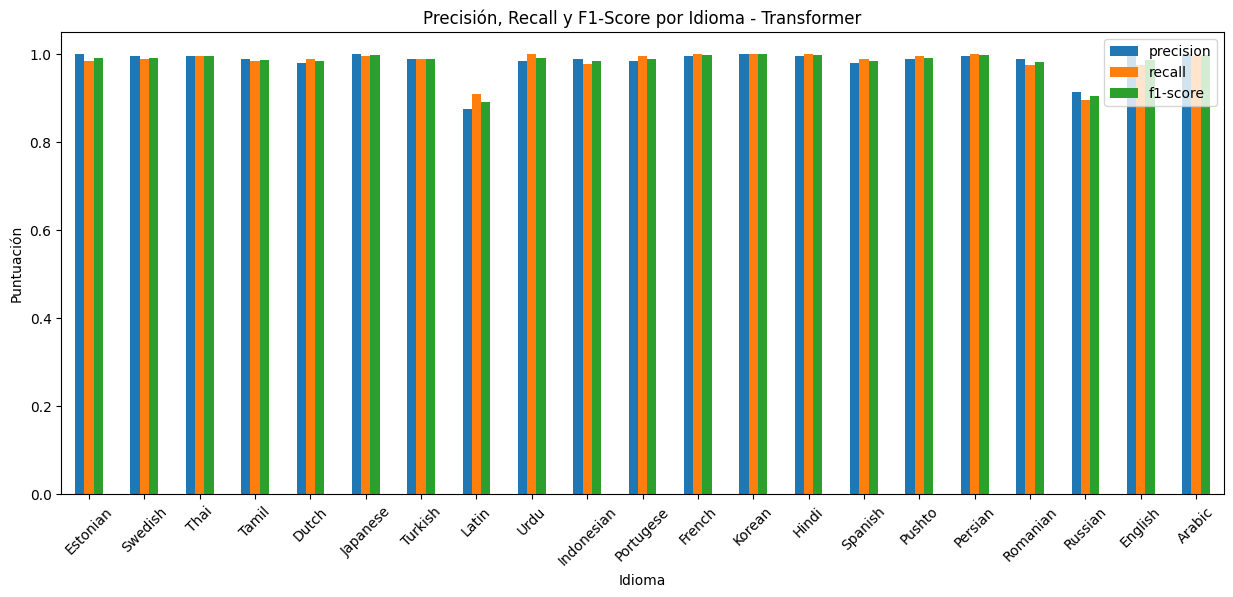

In [28]:
language_names = df['Language'].unique()
report_dict = classification_report(y_test, y_pred, target_names=language_names, output_dict=True)
report_df = pd.DataFrame(report_dict).T[:-3]

report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(15, 6))
plt.title("Precisión, Recall y F1-Score por Idioma - Transformer")
plt.ylabel("Puntuación")
plt.xlabel("Idioma")
plt.xticks(rotation=45)
plt.savefig("plots/transformer_precision_recall_f1.png")
plt.show()

In [21]:
def preprocess_text(texts, tokenizer, max_len=100):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    return padded_sequences

input_text = ["hola este es un texto en español", "hello this is a text in english", "bonjour ceci est un texte en français", "ola isto é um texto em português"]
preprocessed_text = preprocess_text(input_text, tokenizer)

prediction = model.predict(preprocessed_text)
y_prediction = np.argmax(prediction, axis=1)

for i in range(len(input_text)):
    predicted_language = language_names[y_prediction[i]]
    print(f"Texto: {input_text[i]}")
    print(f"Predicción: {predicted_language}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Texto: hola este es un texto en español
Predicción: Spanish

Texto: hello this is a text in english
Predicción: Latin

Texto: bonjour ceci est un texte en français
Predicción: French

Texto: ola isto é um texto em português
Predicción: Portugese



#### Matriz de Confusión

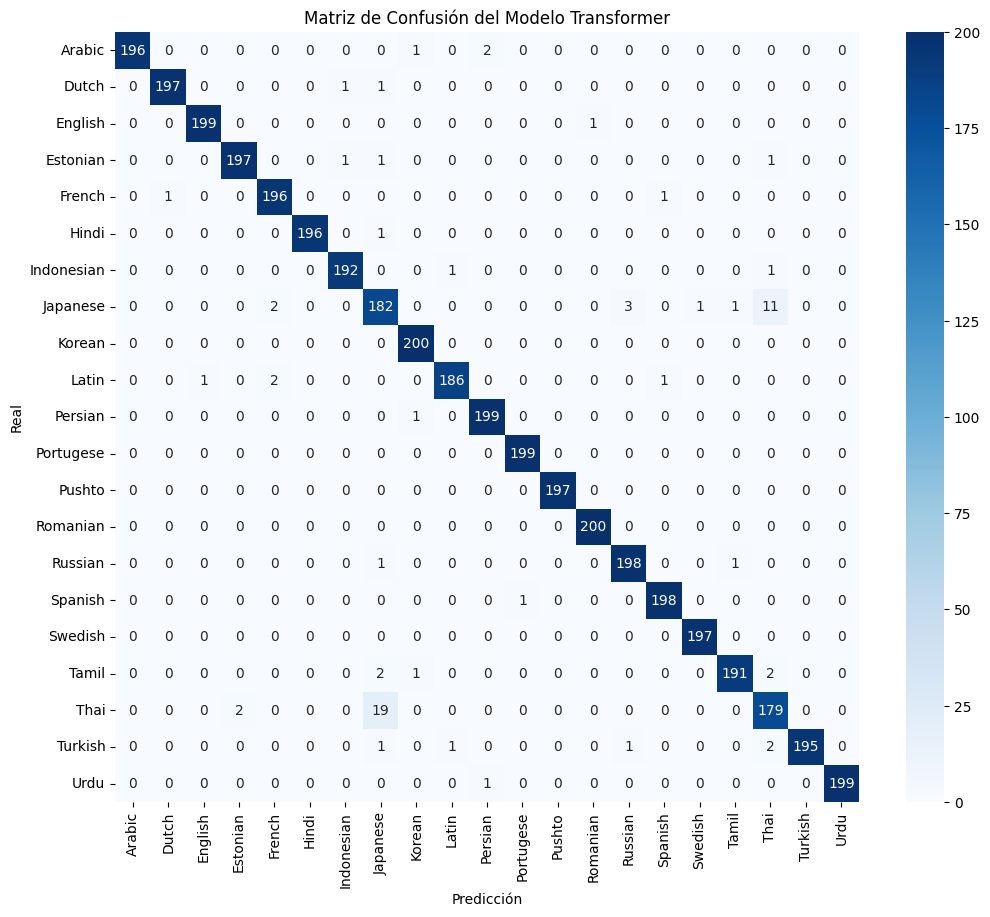

In [22]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=language_names, yticklabels=language_names)
plt.title("Matriz de Confusión del Modelo Transformer")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.savefig("plots/transformer_confusion_matrix.png")
plt.show()

### Matriz de Confusión Normalizada

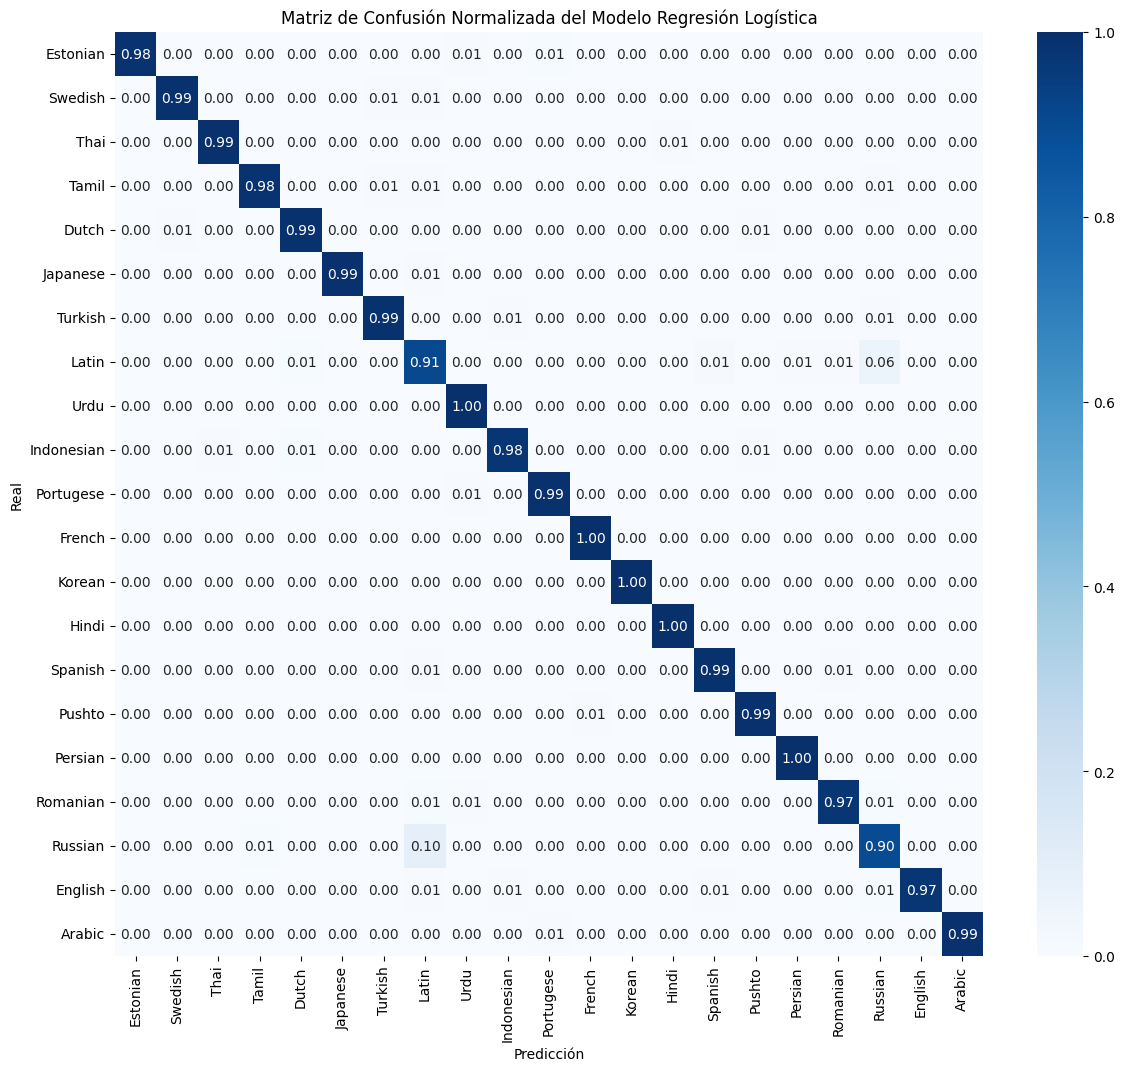

In [23]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=df['Language'].unique(), yticklabels=df['Language'].unique())
plt.title("Matriz de Confusión Normalizada del Modelo Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.savefig("plots/transformer_confusion_matrix_normalized.png")
plt.show()

### Accuracy en Train y Validation

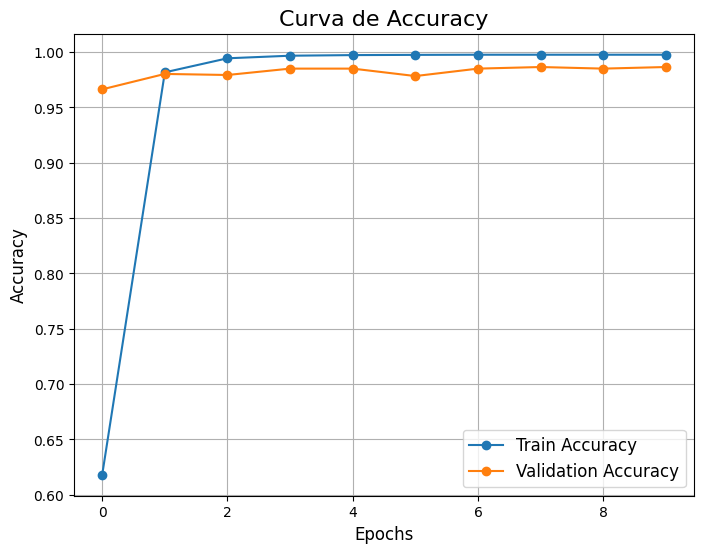

In [24]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Train Accuracy', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Curva de Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig("plots/transformer_accuracy_curve.png")
plt.show()

### Loss en Train y Validation

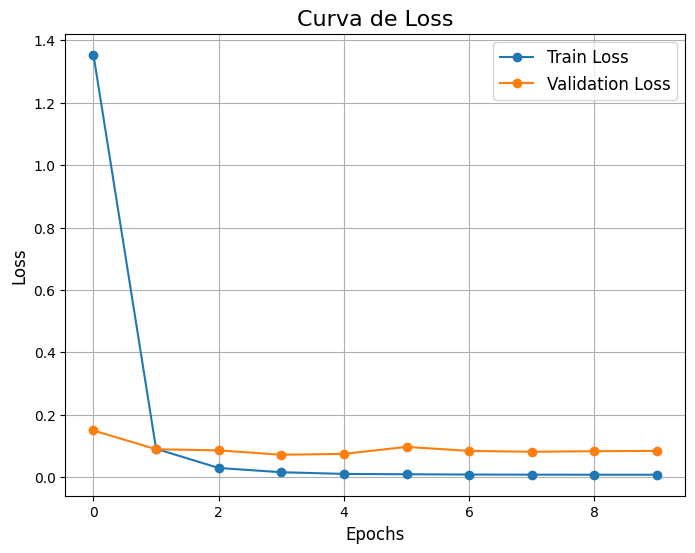

In [25]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Curva de Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig("plots/transformer_loss_curve.png")
plt.show()